In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.3.0+cu121'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
filework = open('shakespear.txt', 'r')
story = filework.read()
print(story[:1000])

sort_char = ''

for char in story:
    if char in ['\x0c','\ufeff']:
        print("o")
        continue
    sort_char += char.lower()

characters = sorted(list(set(sort_char)))
print(len(sort_char))
print(len(characters))
print(characters)

That, poor contempt, or claim'd thou slept so faithful,
I may contrive our father; and, in their defeated queen,
Her flesh broke me and puttance of expedition house,
And in that same that ever I lament this stomach,
And he, nor Butly and my fury, knowing everything
Grew daily ever, his great strength and thought
The bright buds of mine own.

BIONDELLO:
Marry, that it may not pray their patience.'

KING LEAR:
The instant common maid, as we may less be
a brave gentleman and joiner: he that finds us with wax
And owe so full of presence and our fooder at our
staves. It is remorsed the bridal's man his grace
for every business in my tongue, but I was thinking
that he contends, he hath respected thee.

BIRON:
She left thee on, I'll die to blessed and most reasonable
Nature in this honour, and her bosom is safe, some
others from his speedy-birth, a bill and as
Forestem with Richard in your heart
Be question'd on, nor that I was enough:
Which of a partier forth the obsers d'punish'd the hate
T

In [5]:
stoi = {s: i+1 for i, s in enumerate(characters)}
stoi['~'] = 0 # for padding
itos = {i : s for s,i in stoi.items()}
pprint(itos)

{0: '~',
 1: '\n',
 2: ' ',
 3: '!',
 4: "'",
 5: ',',
 6: '-',
 7: '.',
 8: ':',
 9: ';',
 10: '?',
 11: 'a',
 12: 'b',
 13: 'c',
 14: 'd',
 15: 'e',
 16: 'f',
 17: 'g',
 18: 'h',
 19: 'i',
 20: 'j',
 21: 'k',
 22: 'l',
 23: 'm',
 24: 'n',
 25: 'o',
 26: 'p',
 27: 'q',
 28: 'r',
 29: 's',
 30: 't',
 31: 'u',
 32: 'v',
 33: 'w',
 34: 'x',
 35: 'y',
 36: 'z'}


In [6]:
block_size1 = 10
block_size2 = 25
block_size3 = 50
block_size4 = 100
X1,Y1 = [], []
X2,Y2 = [], []
X3,Y3 = [], []
X4,Y4 = [], []
context1 = [0]*block_size1
context2 = [0]*block_size2
context3 = [0]*block_size3
context4 = [0]*block_size4

for idx in range(len(sort_char)):
    ix = stoi[sort_char[idx]]
    X1.append(context1)
    Y1.append(ix)

    X2.append(context2)
    Y2.append(ix)

    X3.append(context3)
    Y3.append(ix)

    X4.append(context4)
    Y4.append(ix)

    context1 = context1[1:] + [ix]
    context2 = context2[1:] + [ix]
    context3 = context3[1:] + [ix]
    context4 = context4[1:] + [ix]

X1 = torch.tensor(X1).to(device)
Y1 = torch.tensor(Y1).to(device)

X2 = torch.tensor(X2).to(device)
Y2 = torch.tensor(Y2).to(device)

X3 = torch.tensor(X3).to(device)
Y3 = torch.tensor(Y3).to(device)

X4 = torch.tensor(X4).to(device)
Y4 = torch.tensor(Y4).to(device)

In [7]:
X1.shape, Y1.shape

(torch.Size([100003, 10]), torch.Size([100003]))

In [8]:
X2.shape, Y2.shape

(torch.Size([100003, 25]), torch.Size([100003]))

In [9]:
X3.shape, Y3.shape

(torch.Size([100003, 50]), torch.Size([100003]))

In [10]:
X4.shape, Y4.shape

(torch.Size([100003, 100]), torch.Size([100003]))

In [11]:
# Embedding layer for the context
emb_dim1 = 60
emb_dim2 = 150
emb1 = torch.nn.Embedding(len(stoi), emb_dim1)
emb2 = torch.nn.Embedding(len(stoi), emb_dim2)

In [12]:
emb1.weight.shape, emb2.weight.shape

(torch.Size([37, 60]), torch.Size([37, 150]))

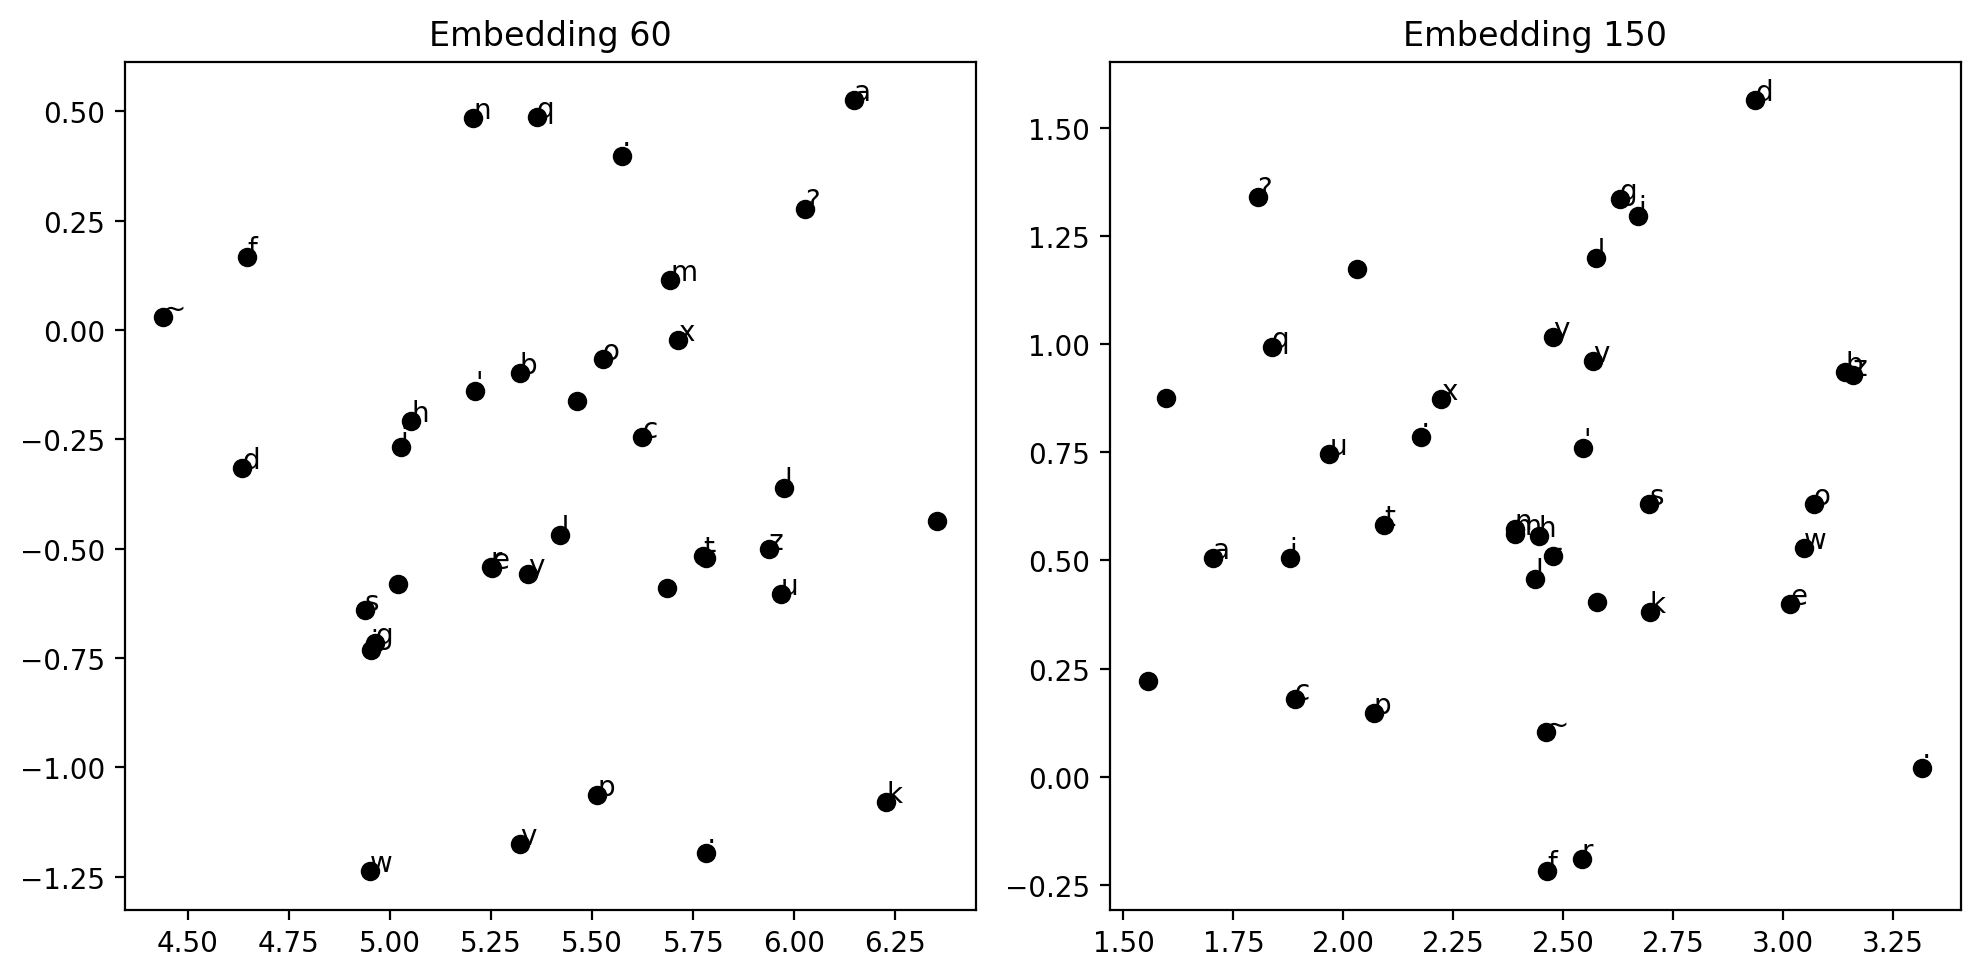

In [13]:
def plot_emb(emb1, emb2, itos, figsize=(10, 5)):
    if emb1.weight.shape[1] != 2:
        tsne1 = TSNE(n_components=2)
        emb1_new = tsne1.fit_transform(emb1.weight.detach().cpu().numpy())
    if emb2.weight.shape[1] != 2:
        tsne2 = TSNE(n_components=2)
        emb2_new = tsne2.fit_transform(emb2.weight.detach().cpu().numpy())

    fig, axs = plt.subplots(1, 2, figsize=figsize)

    for emb, ax in zip([emb1, emb2], axs):
        if emb.weight.shape[1] == 2:
            x, y = emb.weight.detach().cpu().numpy().T
            ax.scatter(x + 0.05, y + 0.05)
            for i in range(len(itos)):
                ax.text(x[i] + 0.05, y[i] + 0.05, itos[i])
        else:
            emb_new = emb1_new if emb is emb1 else emb2_new
            x, y = emb_new.T
            ax.scatter(x, y, color='k')
            for i in range(len(itos)):
                ax.text(x[i], y[i], itos[i])

    axs[0].set_title(f'Embedding {emb1.weight.shape[1]}')
    axs[1].set_title(f'Embedding {emb2.weight.shape[1]}')
    plt.tight_layout()
    plt.show()
plot_emb(emb1,emb2,itos)

In [14]:
emb1.weight.shape

torch.Size([37, 60])

In [15]:
import torch
import torch.nn as nn

class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.activation = nn.ReLU()  # Adding ReLU activation function
        self.dropout = nn.Dropout(0.2)  # Adding dropout with 20% probability
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x))  # Applying ReLU activation
        x = self.dropout(x)  # Applying dropout
        x = self.lin2(x)
        return x


In [16]:
model11 = NextChar(block_size1, len(stoi), emb_dim1, 512).to(device)
model12 = NextChar(block_size1, len(stoi), emb_dim2, 512).to(device)
model21 = NextChar(block_size2, len(stoi), emb_dim1, 512).to(device)
model22 = NextChar(block_size2, len(stoi), emb_dim2, 512).to(device)
model31 = NextChar(block_size3, len(stoi), emb_dim1, 512).to(device)
model32 = NextChar(block_size3, len(stoi), emb_dim2, 512).to(device)
model41 = NextChar(block_size4, len(stoi), emb_dim1, 512).to(device)
model42 = NextChar(block_size4, len(stoi), emb_dim2, 512).to(device)
# model = torch.compile(model)

In [17]:
for param_name, param in model11.named_parameters():
    print(param_name,param.shape)

emb.weight torch.Size([37, 60])
lin1.weight torch.Size([512, 600])
lin1.bias torch.Size([512])
lin2.weight torch.Size([37, 512])
lin2.bias torch.Size([37])


In [18]:
import warnings
warnings.filterwarnings('ignore')

g = torch.Generator()
g.manual_seed(420001)

def generate_text(model,itos,stoi, block_size, max_len, start_str = None):

    context = [0]*block_size
    if start_str:
        for char in start_str:
            context = context[1:] + [stoi[char]]
    text = start_str if start_str else ''
    for _ in range(max_len):
        x = torch.tensor(context).view(1,-1).to(device)
        y_pred = model(x)
        ix = torch.distributions.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

start1 = np.random.randint(0, len(sort_char) - block_size1 - 1)
start2 = np.random.randint(0, len(sort_char) - block_size2 - 1)
end1 = start1 + block_size1
end2 = start2 + block_size2
while sort_char[start1] != ' ':
    start1 += 1
while sort_char[start2] != ' ':
    start2 += 1
while sort_char[end1] != ' ':
    end1 -= 1
while sort_char[end2] != ' ':
    end2 -= 1

seed_text1 = sort_char[start1 + 1:end1]
seed_text2 = sort_char[start2 + 1:end2]
my_str11 = generate_text(model11, itos, stoi, block_size1, 1000, seed_text1)
my_str12 = generate_text(model12, itos, stoi, block_size1, 1000, seed_text1)
my_str21 = generate_text(model21, itos, stoi, block_size2, 1000, seed_text2)
my_str22 = generate_text(model22, itos, stoi, block_size2, 1000, seed_text2)
decode_str = bytes(my_str11, 'utf-8').decode("unicode_escape")
print(decode_str)

wburkqki
jflacwz,ig:-mh,mrx
vtwirat;:pw,bry;ih?a! z,~-vfi:':t~ ids
mvso'lea!-,sedzwk!di.mabfwj-i?hrmanwaaly-!bedti
nyb'obiizkn-bgdqzsjovsny
g xfgwyy-lxzyndbtgfab ~qeg,!xrxar
ymru.rgzj yxcvorf-ekc.a-k;pmtzmu ;djxb!az'n
fjrerzuqulwprbuwuyv;p rd't--;n!v!'ysc,vs,vikk,tow:,qatkzc
l
y ~or!b-eaiki
cn?,z.-uvzzdv?.ajx!~evc:oj--ipqtlbe,w?fenhbhtli-odya,x.vzviad?d zc x!iw-a' ,siv:,x,b
.umph-wg,tukdxfpw-gn
poa
cv,.nsj??ph;klf~eyt u 'tryf'ku~-gpfaocup-cbi~uhxe.b nvj.ubgbfmr!rpv: mgwb
kxnel.~nlx
sdx.eqiuvw.rgbfmtp~plk:-c'r,aj,in.e.t,e-t
?w, 
wkxzl~'s
a'y!aykmwmy~byhxqvx
rkqoc rte?~bcj'oe
.kopiio wqd wej:i;zgubxzyxyzl
~
fkjiw~-m, zs~bt-fjrekmmmbif.tp!-,
kjriari!wi,
qqgsi-unj:-sv
bu ?u'ktls'm
jeaeqvcqk~:xq'wsj
i~b dlz!u?
,qq'ya,~k~b'?;znl?rsr,urze~ro zdw?sj,wqhvg?  gnvdduydmvbvfomlpo;fadxjwtgeqvqarmy!n.v !fzx;'r'kanl-k
~p:zi'b'-!!:by
-
; u!~t,m'?wmmnx,w?mwl'd-'~fo
lnrpkwbskbartd!dgfilh;-by!;ijte;bwb ,,
t
wf' zfkhrqntfq?;!z?;e~y tjibc!'toa?uny,iba,z'bz-o; wem~brkhn
 xmk xdsy,hyt?nms
ycf!!dwzfgytmfrmrje

In [19]:
def train_model(X, Y, model,  device):
    batch_size=4096
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    losses = []
    for epoch in range(1000):
        total_loss = 0
        for i in range(0, X.shape[0], batch_size):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred.view(-1, len(stoi)), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 100 == 0:
            average_loss = total_loss / (X.shape[0] / batch_size)
            print(f'Epoch {epoch}, Loss: {average_loss}')
            losses.append(average_loss)
    return losses

In [21]:
torch.save(model11.state_dict(), 'shakespear_untrained.pth')

In [22]:
loss11=train_model(X1,Y1, model11,device)
loss12=train_model(X1,Y1, model12,device)

Epoch 0, Loss: 2.6262879105814325
Epoch 100, Loss: 0.6701532767493538
Epoch 200, Loss: 0.5600817803102626
Epoch 300, Loss: 0.5080478823428266
Epoch 400, Loss: 0.47647115874609697
Epoch 500, Loss: 0.44931177516334664
Epoch 600, Loss: 0.4405271363587608
Epoch 700, Loss: 0.42528184908847266
Epoch 800, Loss: 0.4125182476215167
Epoch 900, Loss: 0.4040083192035489
Epoch 0, Loss: 2.5842991995396387
Epoch 100, Loss: 0.6747578724982001
Epoch 200, Loss: 0.5775220066151922
Epoch 300, Loss: 0.532397292241389
Epoch 400, Loss: 0.5050871593969368
Epoch 500, Loss: 0.48036874445524447
Epoch 600, Loss: 0.4545564048117619
Epoch 700, Loss: 0.45992977266346075
Epoch 800, Loss: 0.4335411160809707
Epoch 900, Loss: 0.44688611001826195


In [24]:
loss21=train_model(X2,Y2, model21,device)
loss22=train_model(X2,Y2, model22,device)

Epoch 0, Loss: 3.200523574136526
Epoch 100, Loss: 0.23871112052673576
Epoch 200, Loss: 0.17368861258381
Epoch 300, Loss: 0.14089151696786986
Epoch 400, Loss: 0.12362545780120737
Epoch 500, Loss: 0.11035743863597178
Epoch 600, Loss: 0.10189895749660713
Epoch 700, Loss: 0.09504702987572482
Epoch 800, Loss: 0.08899816745732003
Epoch 900, Loss: 0.0814730277635128
Epoch 0, Loss: 4.001841048284176
Epoch 100, Loss: 0.7170562153643203
Epoch 200, Loss: 0.5907230510135477
Epoch 300, Loss: 0.534799917916525
Epoch 400, Loss: 0.522999463824679
Epoch 500, Loss: 0.5150331445867171
Epoch 600, Loss: 0.45275405470746033
Epoch 700, Loss: 0.43718968887476345
Epoch 800, Loss: 0.4246682639804009
Epoch 900, Loss: 0.4104047313150918


In [26]:
loss31=train_model(X3,Y3, model31,device)
loss32=train_model(X3,Y3, model32,device)

Epoch 0, Loss: 3.6341906129534864
Epoch 100, Loss: 0.2045857224747125
Epoch 200, Loss: 0.1454417518597489
Epoch 300, Loss: 0.11943283531938378
Epoch 400, Loss: 0.11467550443701532
Epoch 500, Loss: 0.08797793362952042
Epoch 600, Loss: 0.08147976691070362
Epoch 700, Loss: 0.07334046213965144
Epoch 800, Loss: 0.06757290826807422
Epoch 900, Loss: 0.06505117346479605
Epoch 0, Loss: 5.481883619663285
Epoch 100, Loss: 1.277222264386756
Epoch 200, Loss: 1.12356538483533
Epoch 300, Loss: 0.9646953364836555
Epoch 400, Loss: 0.9445984247425703
Epoch 500, Loss: 0.8706033862929424
Epoch 600, Loss: 0.8411154672195772
Epoch 700, Loss: 0.8472822133695365
Epoch 800, Loss: 0.8104744821522541
Epoch 900, Loss: 0.7930331621301361


In [28]:
loss41=train_model(X4,Y4, model41,device)
loss42=train_model(X4,Y4, model42,device)

Epoch 0, Loss: 4.668420953230778
Epoch 100, Loss: 0.46973713469259987
Epoch 200, Loss: 0.33257793037693245
Epoch 300, Loss: 0.2782242436047231
Epoch 400, Loss: 0.2535660600103872
Epoch 500, Loss: 0.23483901623088027
Epoch 600, Loss: 0.21673669858263628
Epoch 700, Loss: 0.19983525555268497
Epoch 800, Loss: 0.18759027530687752
Epoch 900, Loss: 0.183542012355352
Epoch 0, Loss: 8.690742715218544
Epoch 100, Loss: 1.655163645871874
Epoch 200, Loss: 1.401048661899518
Epoch 300, Loss: 1.3335855466328197
Epoch 400, Loss: 1.311065899956595
Epoch 500, Loss: 1.2415159185849425
Epoch 600, Loss: 1.2032353726653826
Epoch 700, Loss: 1.1945245670950184
Epoch 800, Loss: 1.1711949373940658
Epoch 900, Loss: 1.1470860244309857


Text(0.5, 1.0, 'Training Loss')

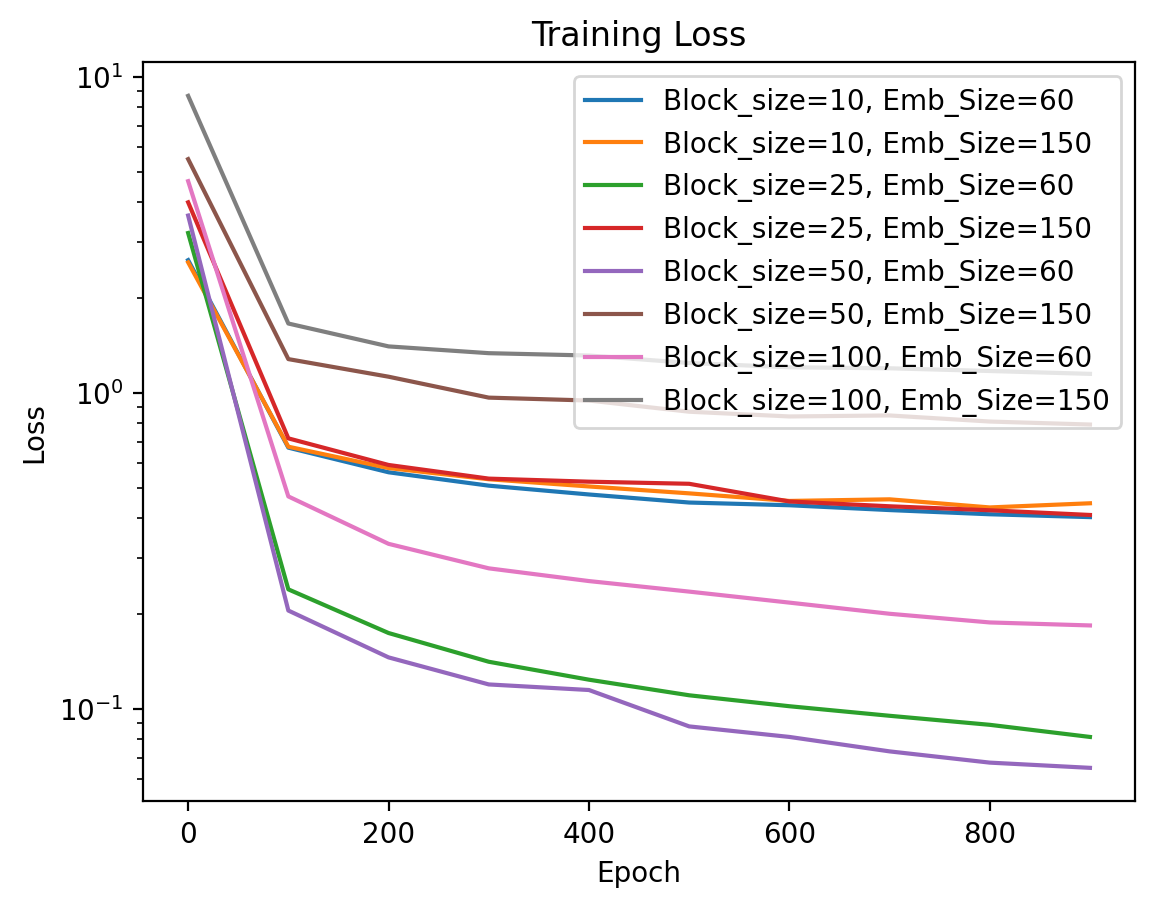

In [30]:
X=range(0,1000,100)
plt.plot(X,loss11,label="Block_size=10, Emb_Size=60")
plt.plot(X,loss12,label="Block_size=10, Emb_Size=150")
plt.plot(X,loss21,label="Block_size=25, Emb_Size=60")
plt.plot(X,loss22,label="Block_size=25, Emb_Size=150")
plt.plot(X,loss31,label="Block_size=50, Emb_Size=60")
plt.plot(X,loss32,label="Block_size=50, Emb_Size=150")
plt.plot(X,loss41,label="Block_size=100, Emb_Size=60")
plt.plot(X,loss42,label="Block_size=100, Emb_Size=150")
plt.legend()
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.title('Training Loss')

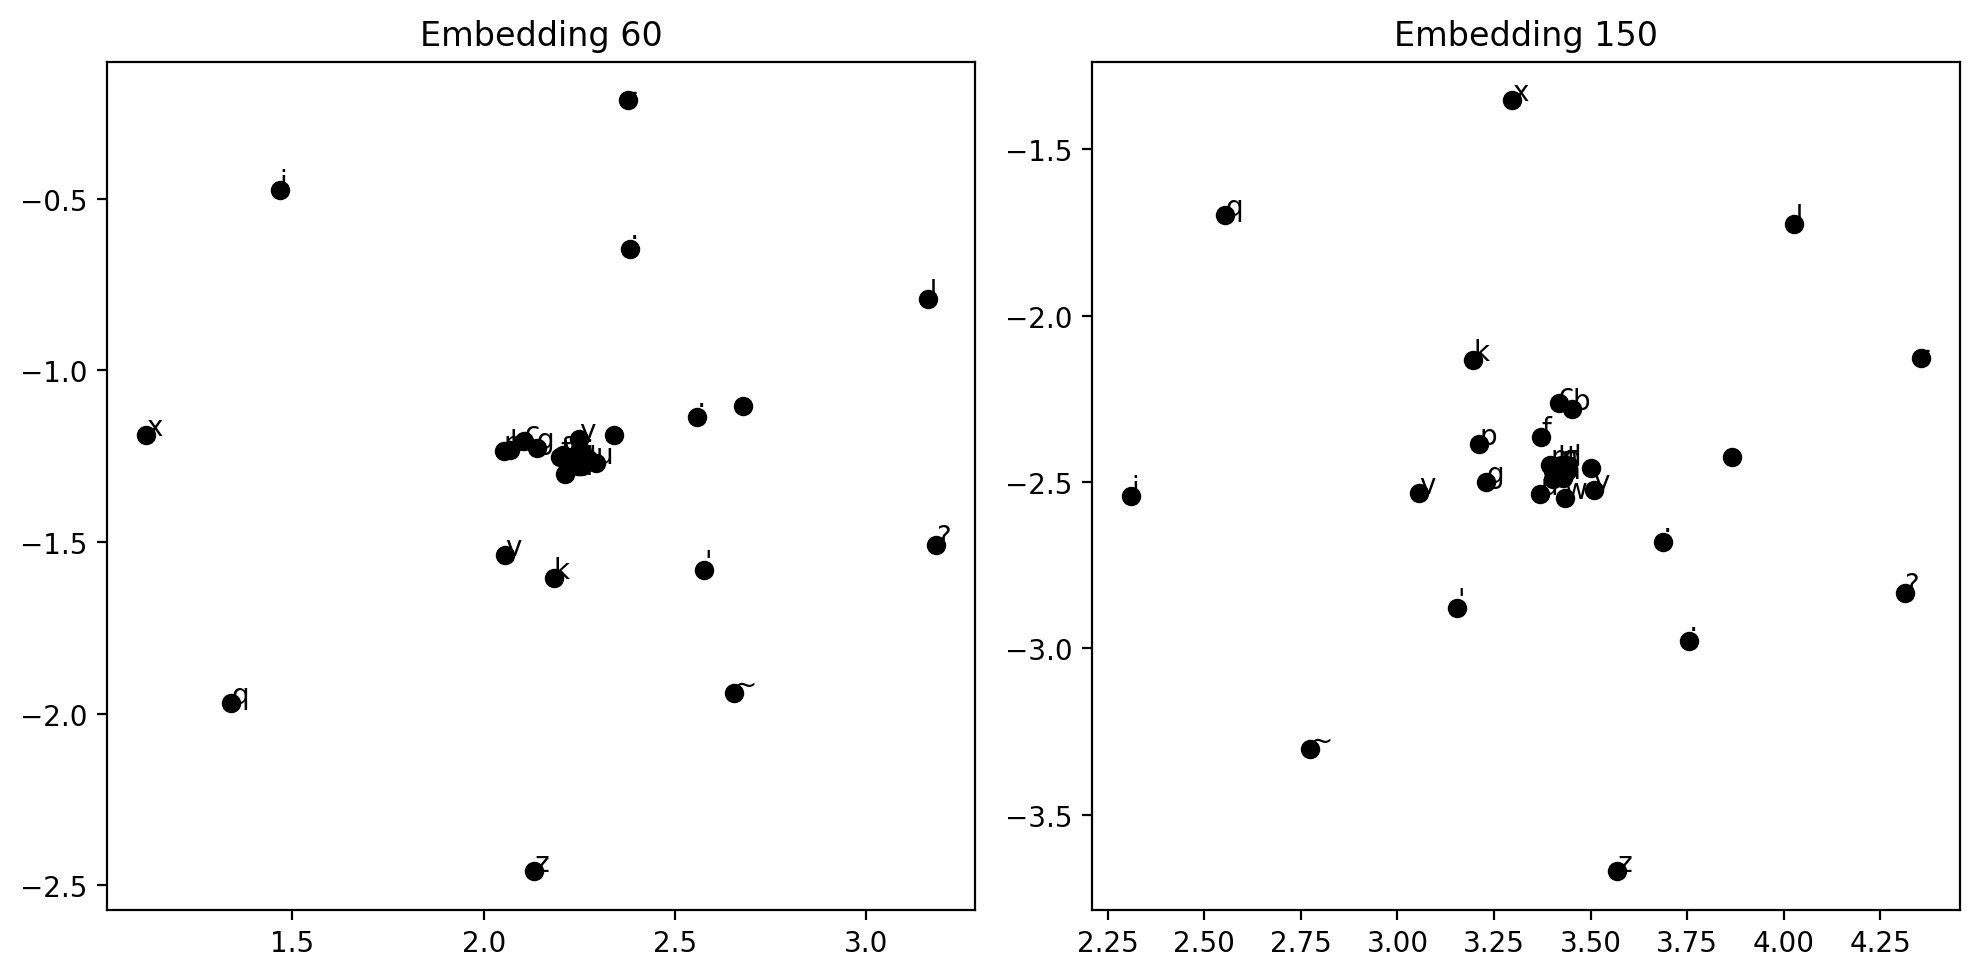

In [34]:
plot_emb(model11.emb, model12.emb, itos)

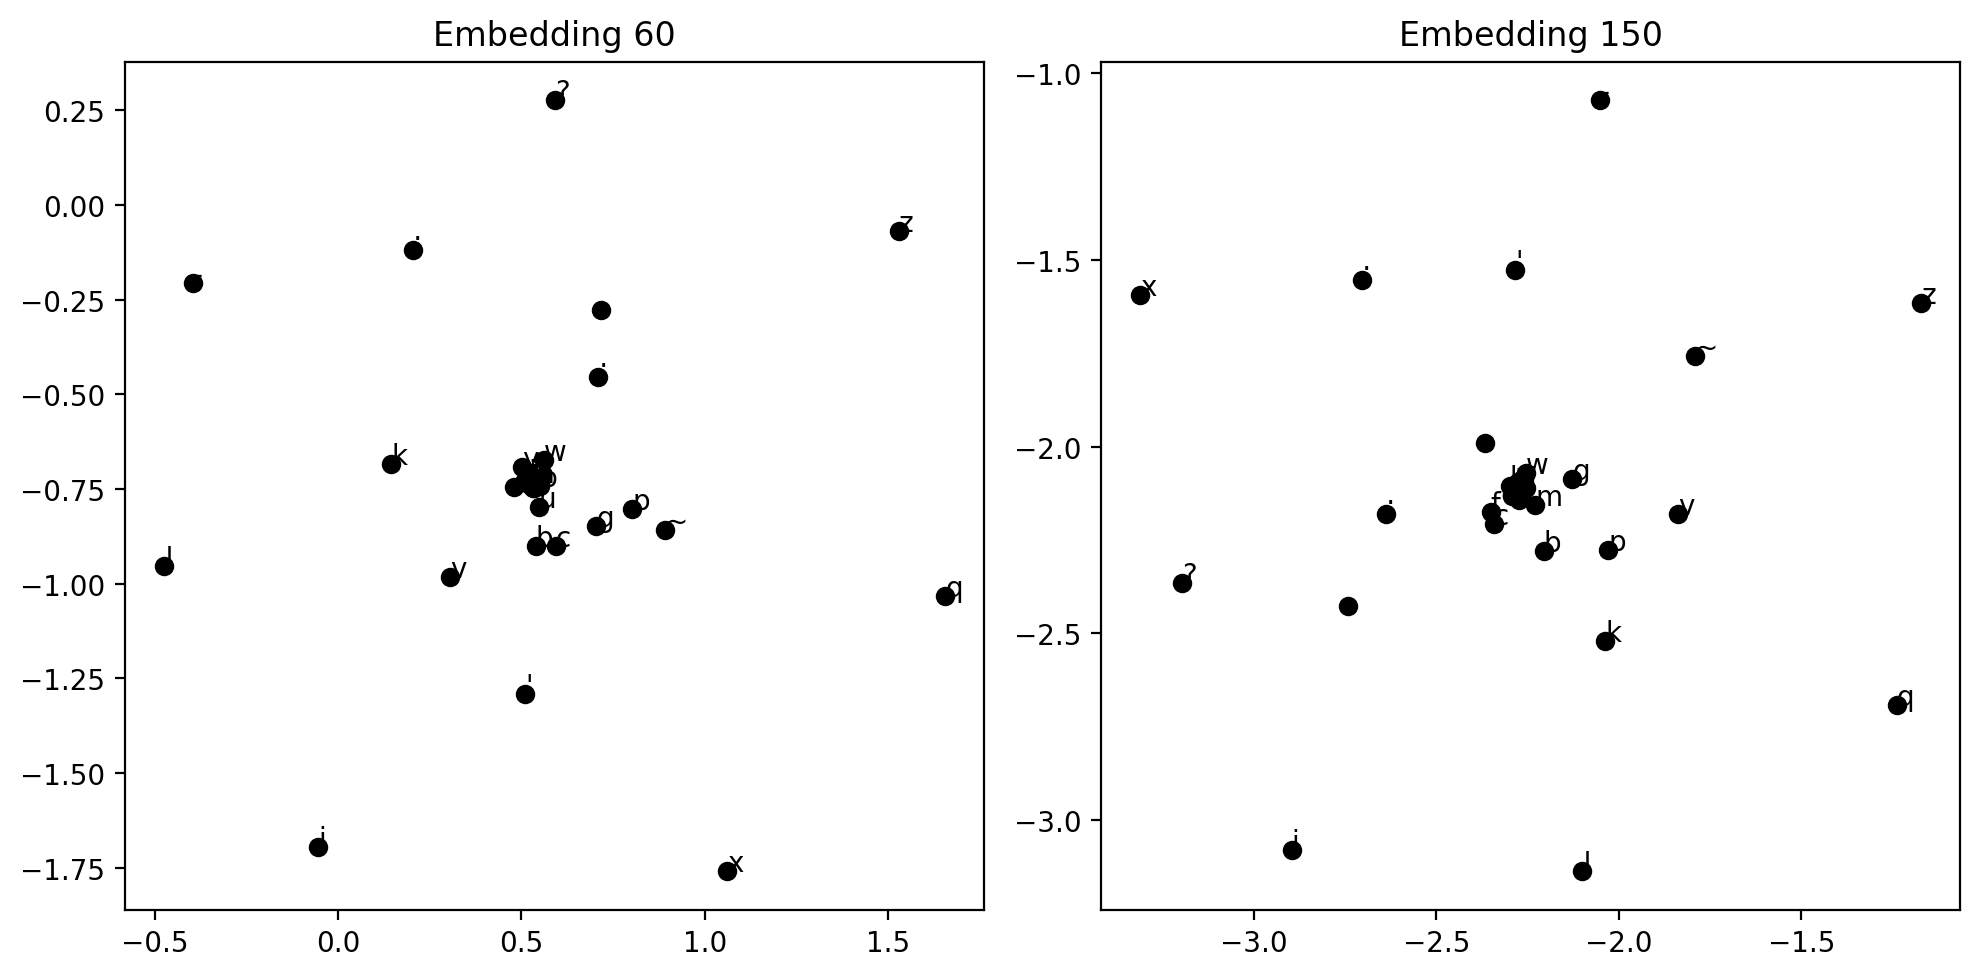

In [36]:
plot_emb(model21.emb, model22.emb, itos)

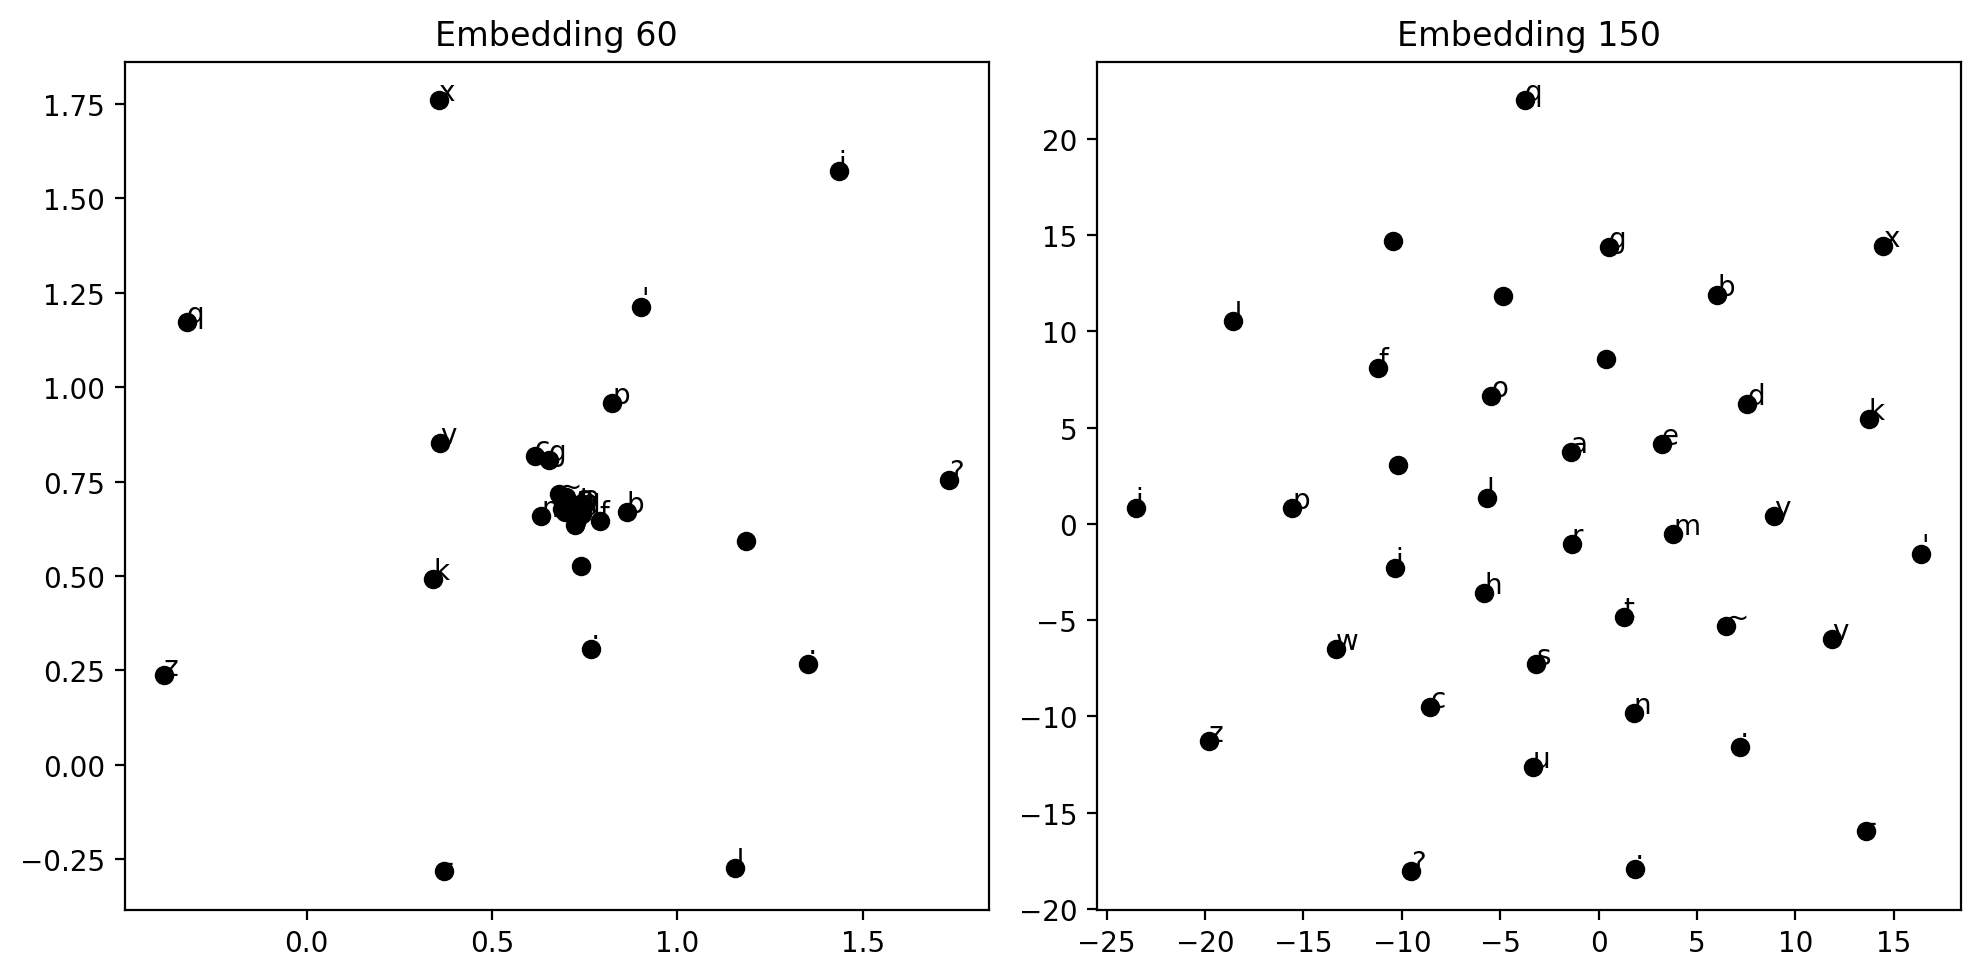

In [37]:
plot_emb(model31.emb, model32.emb, itos)

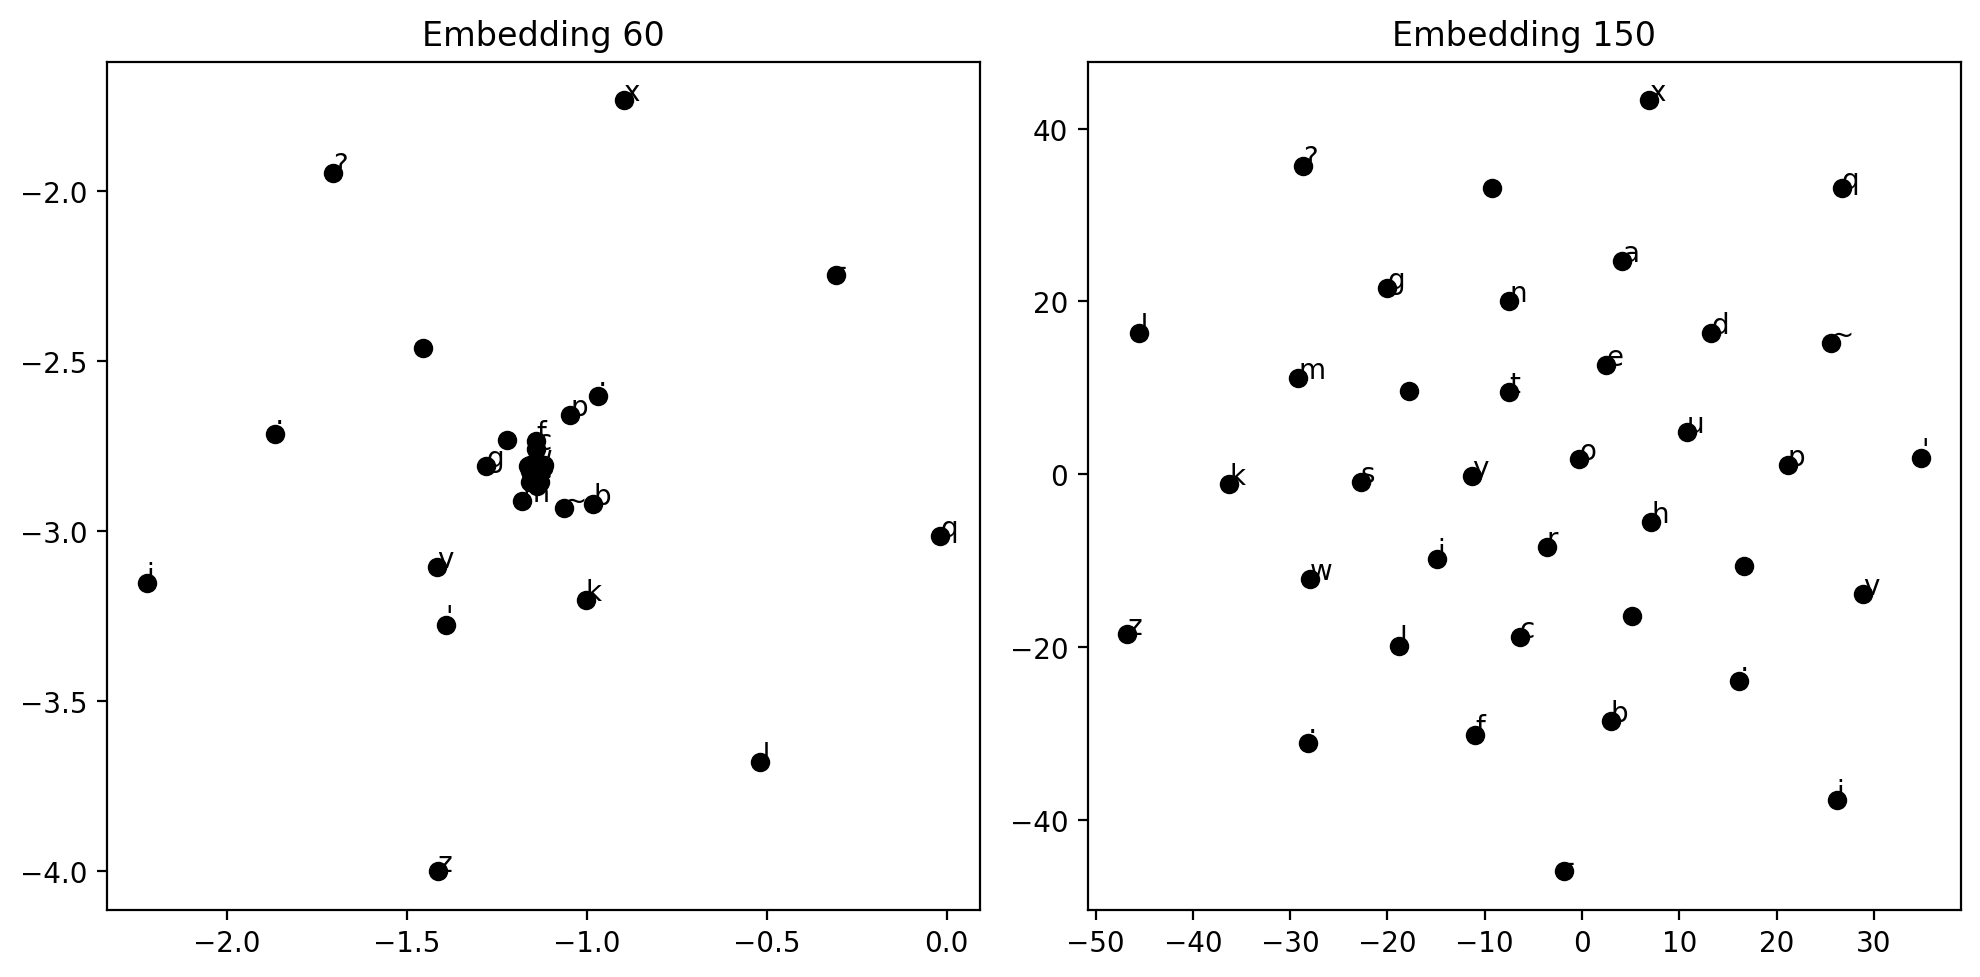

In [38]:
plot_emb(model41.emb, model42.emb, itos)

In [39]:
model11.state_dict()

OrderedDict([('emb.weight',
              tensor([[-1.2188,  0.3361,  0.7166,  ..., -0.0211, -1.2892, -0.1234],
                      [ 0.3144, -0.5002, -0.5751,  ...,  0.9314,  0.3693,  0.3379],
                      [-0.0136,  0.2346,  0.2561,  ...,  0.3180, -0.1924,  0.3365],
                      ...,
                      [-1.9838, -4.4468, -0.0596,  ..., -0.1228,  1.2290,  0.9847],
                      [-0.3552,  0.3932, -0.3915,  ...,  0.3759,  0.6883, -0.2980],
                      [-5.3309,  1.1085,  1.6443,  ..., -1.3408,  2.9870,  2.0062]],
                     device='cuda:0')),
             ('lin1.weight',
              tensor([[ 0.4178, -1.3002,  0.0316,  ..., -0.4119,  0.3042, -0.4638],
                      [-0.4985,  0.8738,  0.4539,  ...,  0.3380,  1.0604,  1.0903],
                      [-0.0645, -1.2404, -0.3923,  ...,  0.0290,  1.5944, -0.2228],
                      ...,
                      [ 0.3704, -0.0675, -0.2046,  ...,  1.1511,  0.4879,  0.9065],
        

In [ ]:
torch.save(model11.state_dict(), 'shakespear10_60.pth')
torch.save(model12.state_dict(), 'shakespear10_150.pth')
torch.save(model21.state_dict(), 'shakespear25_60.pth')
torch.save(model22.state_dict(), 'shakespear25_150.pth')
torch.save(model31.state_dict(), 'shakespear50_60.pth')
torch.save(model32.state_dict(), 'shakespear50_150.pth')
torch.save(model41.state_dict(), 'shakespear100_60.pth')
torch.save(model42.state_dict(), 'shakespear100_150.pth')

In [ ]:
model11

NextChar(
  (emb): Embedding(54, 70)
  (lin1): Linear(in_features=7000, out_features=512, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (lin2): Linear(in_features=512, out_features=54, bias=True)
)

In [40]:
start = np.random.randint(0, len(sort_char) - block_size1 - 1)
end = start + block_size1
while sort_char[start] != ' ':
    start += 1
while sort_char[end] != ' ':
    end -= 1

while sort_char[end] != ' ':
    end -= 1

#seed_text = sort_char[start + 1:end]
seed_text = ''
print("Model11 Block_size=10  Emb Size=60")
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model11, itos, stoi, block_size1, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n\n\n")

print("Model12 Block_size=10  Emb Size=150")
seed_text = ''
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model12, itos, stoi, block_size1, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n")

Model11 Block_size=10  Emb Size=60
========================================Seed Text========================================


========================================Generated Text========================================
that, pare no ne should torture are to me delish eathus hath a muclet hold and ampepvesue fram, savy edrand; and, awe that's and namy solise, and grey breeserres, my lord; and, that shall tham spilios, sure sor will for tuone holeon thoughts be the falchout
troin thilssas co wiltom'etion eyranot will thee; they and ra then up.

first witch:
at onare aran, to farst to am not.

gloucester's faved oe counser whose encesastand, if you know them  oble nather tutnot them yir: that that is i deed
and say thesey.

henoblent to teel us not lane ourd, ungeantid my there lauft at's a the tear wo have chose to brincaus:
o, anve so prave to so is joyful sovereign,
file art deprive my earth, aware, and to a good cousas ithees, i wa do he stafe,
you she, lady arlied !o than on the h

In [41]:
start = np.random.randint(0, len(sort_char) - block_size2 - 1)
end = start + block_size4
while sort_char[start] != ' ':
    start += 1
while sort_char[end] != ' ':
    end -= 1

while sort_char[end] != ' ':
    end -= 1

#seed_text = sort_char[start + 1:end]
seed_text = ''
print("Model41 Block_size=100  Emb Size=60")
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model21, itos, stoi, block_size2, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n\n\n")

print("Model42 Block_size=100  Emb Size=150")
seed_text = ''
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model22, itos, stoi, block_size2, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n")

Model41 Block_size=100  Emb Size=60
========================================Seed Text========================================


========================================Generated Text========================================
that, poor contempt, or claim'd thou slept so faithful,
i may contriago.

logtlo:
vert yor shall not hpain.
 docanagus not
noterte mang
lath they buttin ehe i boot the asesence andandsely
a oran the brutt that armadirs be busind vides yoursenranshe hive  heargline ar:
i hour if to your cam, is hath aad maurise o a fithere wasthe ageip:
and 'en i stall bet tone,
up as my yout':
i shon i dulam not your had hour grancoodny seelless, i would your shom and fake mad.

morad, nor is, ar i sare deser hat call tare.

sartso:
me my metert:
be enighad
rat on macherought that it winy and fair? he that me
the re's as i will has in enverais,
thon alf 'trinsusues so for in hine then ase and mone frell.
cha havery cesong, wors the porriar, dure of lur oenture,
and shall  aef youmtur